# E-tivity 5: Tasks and Discussion

### Name: Barry O' Dubhain
### Student ID: 21384401

## Task 2
Repeat the experiment in Lab5 - Regression and Dimensionality Reduction.ipynb with insurance.csv and draw conclusions from the results you observe in a markdown cell. Add a third regression algorithm of your choice. Describe how it compares to Random Forest and Linear regression in a markdown cell (max 250 words in a markdown cell).

In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, RobustScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

# imports necessary for dimensionality reduction
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn import svm

# regression algorithms
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

# metrics for evaluating regression models
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import warnings
warnings.filterwarnings('ignore')

## EDA

We start with a brief EDA to check for missing values and outliers.

In [2]:
df = pd.read_csv("./insurance.csv")

In [3]:
df.head()

age  gender     bmi  children smoker     region  insurance_cost
0   18    male  33.770         1     no  southeast      1725.55230
1   18    male  34.100         0     no  southeast      1137.01100
2   18  female  26.315         0     no  northeast      2198.18985
3   18  female  38.665         2     no  northeast      3393.35635
4   18  female  35.625         0     no  northeast      2211.13075

In [4]:
df.tail()

age  gender     bmi  children smoker     region  insurance_cost
1333   64  female  31.825         2     no  northeast     16069.08475
1334   64  female  26.885         0    yes  northwest     29330.98315
1335   64    male  26.410         0     no  northeast     14394.55790
1336   64    male  36.960         2    yes  southeast     49577.66240
1337   64    male  23.760         0    yes  southeast     26926.51440

In [5]:
df.isna().sum()

age               0
gender            0
bmi               0
children          0
smoker            0
region            0
insurance_cost    0
dtype: int64

There are no obvious missing values. Let's also examine the basic statistics of the numerical attributes.

In [6]:
df.describe()

age          bmi     children  insurance_cost
count  1338.000000  1338.000000  1338.000000     1338.000000
mean     39.207025    30.663397     1.094918    13270.422265
std      14.049960     6.098187     1.205493    12110.011237
min      18.000000    15.960000     0.000000     1121.873900
25%      27.000000    26.296250     0.000000     4740.287150
50%      39.000000    30.400000     1.000000     9382.033000
75%      51.000000    34.693750     2.000000    16639.912515
max      64.000000    53.130000     5.000000    63770.428010

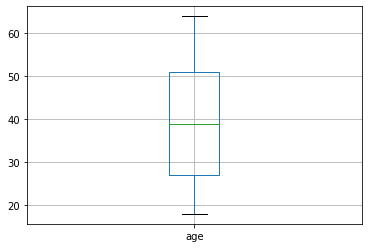

In [7]:
df.boxplot(column=['age'])
plt.show()

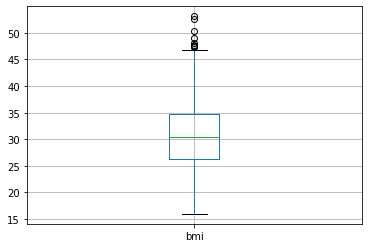

In [8]:
df.boxplot(column=['bmi'])
plt.show()

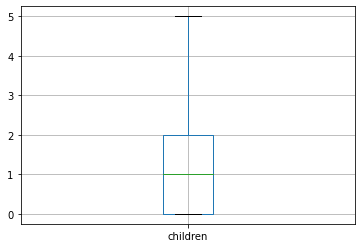

In [9]:
df.boxplot(column=['children'])
plt.show()

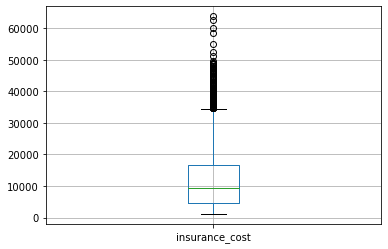

In [10]:
df.boxplot(column=['insurance_cost'])
plt.show()

BMI and insurance cost show outliers but these appear to be within reason. None of the rows need to be dropped as there are no missing or anomolous values.

In [11]:
df = pd.get_dummies(df, columns=['gender'], 
                        #dummy_na=True, 
                        drop_first=True)

In [12]:
df = pd.get_dummies(df, columns=['smoker'], 
                        #dummy_na=True, 
                        drop_first=True)

In [13]:
df = pd.get_dummies(df, columns=['region'], 
                        #dummy_na=True, 
                        drop_first=True)

In [14]:
df.head()

age     bmi  children  insurance_cost  gender_male  smoker_yes  \
0   18  33.770         1      1725.55230            1           0   
1   18  34.100         0      1137.01100            1           0   
2   18  26.315         0      2198.18985            0           0   
3   18  38.665         2      3393.35635            0           0   
4   18  35.625         0      2211.13075            0           0   

   region_northwest  region_southeast  region_southwest  
0                 0                 1                 0  
1                 0                 1                 0  
2                 0                 0                 0  
3                 0                 0                 0  
4                 0                 0                 0

Since there are no obvious outliers, we will apply StandardScaler to all predictor columns with a pre-rpocessing pipeline.

In [15]:
preprocess_pipeline = make_pipeline(StandardScaler())

Now we can separate the columns into target and predictors and split the dataset into a training and test sets.

In [16]:
y = df['insurance_cost']
X = df.drop('insurance_cost', axis=1).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

### Grid Search for Best Parameters and Best Dimensionality Reduction Method

Next, we train RandomForestRegressor on the training set with a range of possible parameters in order to find the best parameters by cross-validation. To do this we will build another [main] pipeline which includes the preprocessing pipeline and RandomForestRegressor. We also add an element for dimensionality reduction after the preprocessing pipeline.

Here we will attempt three different dimensionality reduction methods and we will let the grid search pick the best one. These are:

    Principal Component Analysis (PCA)
    Recursive Feature Elimination (RFE) with estimator svm.SVR
    Recursive Feature Elimination (RFE) with estimator LinearRegression

Note that RFE is using regression algorithms for selecting the best features. These regression algorithms can be different from the regression algorithm at the end of the main pipeline.

The main pipeline will take care for separately preprocessing the training and validation sets after the training set is further split into training and validation sets in the process of cross-validation. It also applies the dimensionality reduction method separately to the two sets.

### Random Forest Pipeline

The pipeline contains a placeholder for the dimensionality reduction method. We will treat the method as a parameter and let the grid search pick the best of the three methods.

In [17]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                       ('reduce_dim', 'passthrough'),
                       ('regresson', RandomForestRegressor(n_estimators=10))])

In [18]:
N_FEATURES_OPTIONS = [2, 3, 4, 5, 6, 7, 8]
MAX_DEPTH_OPTIONS = [2, 4, 6, 8]
N_EST_OPTIONS = [10, 20, 30]
MAX_FTRS_OPTIONS = ["auto", "sqrt", "log2"]
BTSTRP_OPTIONS = [True, False]

param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regresson__max_depth': MAX_DEPTH_OPTIONS,
        'regresson__n_estimators': N_EST_OPTIONS,
        'regresson__max_features': MAX_FTRS_OPTIONS,
        'regresson__bootstrap': BTSTRP_OPTIONS
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')),  RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'regresson__max_depth': MAX_DEPTH_OPTIONS,
        'regresson__n_estimators': N_EST_OPTIONS,
        'regresson__max_features': MAX_FTRS_OPTIONS,
        'regresson__bootstrap': BTSTRP_OPTIONS
    }  
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)

print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
RF_best_params = search.best_params_
RF_best_model = search.best_estimator_

Best CV score = 0.862:
Best parameters:  {'reduce_dim': RFE(estimator=SVR(gamma='auto', kernel='linear'), n_features_to_select=8), 'reduce_dim__n_features_to_select': 8, 'regresson__bootstrap': True, 'regresson__max_depth': 4, 'regresson__max_features': 'auto', 'regresson__n_estimators': 10}


The parameter refit=True makes the GridSearchCV train a RandomForestRegressor model on the whole training set with the best parameters and the best dimensionality reduction method found. This best model can then be accessed via the .best_estimator_ attribute of the GridSearchCV.

Let's repeat the same experiment but with LinearRegression for training a regression model.


### Linear Regression Pipeline

In [19]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                       ('reduce_dim', 'passthrough'),
                       ('regresson', LinearRegression())])

In [20]:
N_FEATURES_OPTIONS = [2, 6, 11]
NORMALIZE_OPTIONS = [False, True]

param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regresson__normalize': NORMALIZE_OPTIONS
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')),RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'regresson__normalize': NORMALIZE_OPTIONS
    }  
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
LR_best_params = search.best_params_
LR_best_model = search.best_estimator_

Best CV score = 0.749:
Best parameters:  {'reduce_dim': RFE(estimator=LinearRegression(), n_features_to_select=6), 'reduce_dim__n_features_to_select': 6, 'regresson__normalize': False}


### Compare Regression Models on Test Set

Now we can evaluate the best models found by the grid search on the test dataset and compare their metrics:

    mean squared error (MSE)
    mean absolute error (MAE)
    1-relative squared error (R2)

to choose the better regressor for our problem.

In [21]:
# model - a trained regression model

def evaluate_model(X_test, y_test, model):
    
    # compute predictiond for the test set
    _predicted_values = model.predict(X_test)
        
    # compute metrics
    _mse = mean_squared_error(y_test, _predicted_values)
    _mae = mean_absolute_error(y_test, _predicted_values)
    _r2 = r2_score(y_test, _predicted_values)
            
    return _mse, _mae, _r2

In [22]:
RF_mse, RF_mae, RF_r2 = evaluate_model(X_test, y_test, RF_best_model)
LR_mse, LR_mae, LR_r2 = evaluate_model(X_test, y_test, LR_best_model)

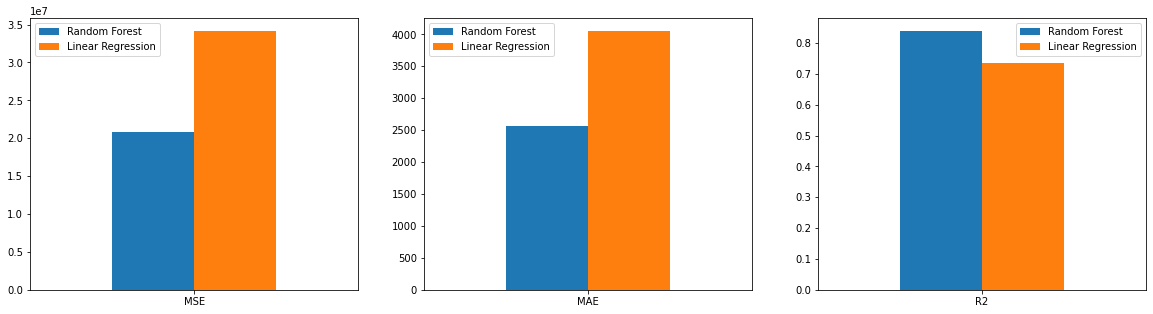

In [23]:
df_mse = pd.DataFrame({'Random Forest': RF_mse, 'Linear Regression': LR_mse}, index=['MSE'])
df_mae = pd.DataFrame({'Random Forest': RF_mae, 'Linear Regression': LR_mae}, index=['MAE'])
df_r2 = pd.DataFrame({'Random Forest': RF_r2, 'Linear Regression': LR_r2}, index=['R2'])

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

df_mse.plot.bar(rot=0, ax=axes[0])
df_mae.plot.bar(rot=0, ax=axes[1])
df_r2.plot.bar(rot=0, ax=axes[2])

plt.show()

This tests confirms that Random Forest is the better regression model with lower MSE and MAE and higher R2.

### Train a Final Model

In [24]:
# function to remove the string 'regresson__' from the names of the best parameters
def transform(dict, prefix):
    dict_prefix = {key:value for key,value in dict.items() if prefix in key}
    return {key.replace(prefix,''):value for key,value in dict_prefix.items()}

pipe = make_pipeline(preprocess_pipeline, 
                     RF_best_params.get('reduce_dim'),
                     RandomForestRegressor(**transform(RF_best_params, 'regresson__')))

final_model =pipe.fit(X, y)

## Task 3
Add two dimensionality-reduction methods which are not used in CS5062 - Lab5 - Regression and Dimensionality Reduction.ipynb to the training pipelines for insurance.csv. Aim at dimensionality reduction techniques that are sufficiently different from the ones used in the example notebook. Draw conclusions from the results you observe in a markdown cell (max 250 words in a markdown cell).

In [25]:
from sklearn.manifold import Isomap
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.decomposition import TruncatedSVD

### Random Forest

#### Dimensionality reduction algorithms used:

SVD (Singular Value Decomposition) - Singular Value Decomposition, or SVD, is one of the most popular techniques for dimensionality reduction for sparse data (data with many zero values)

Isomap Embedding - Isomap Embedding, or Isomap, creates an embedding of the dataset and attempts to preserve the relationships in the dataset.

In [26]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                       ('reduce_dim', 'passthrough'),
                       ('regresson', RandomForestRegressor(n_estimators=10))])

In [27]:
N_FEATURES_OPTIONS = [2, 3, 4, 5, 6, 7, 8]
MAX_DEPTH_OPTIONS = [2, 4, 6, 8]
N_EST_OPTIONS = [10, 20, 30]
MAX_FTRS_OPTIONS = ["auto", "sqrt", "log2"]
BTSTRP_OPTIONS = [True, False]
DIM_REDUCTION = [Isomap(n_components=10), TruncatedSVD(n_components=10)]

param_grid = [
        {
        'reduce_dim': DIM_REDUCTION,
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regresson__max_depth': MAX_DEPTH_OPTIONS,
        'regresson__n_estimators': N_EST_OPTIONS,
        'regresson__max_features': MAX_FTRS_OPTIONS,
        'regresson__bootstrap': BTSTRP_OPTIONS
        }
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)

print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
RF_best_params = search.best_params_
RF_best_model = search.best_estimator_

Best CV score = 0.808:
Best parameters:  {'reduce_dim': TruncatedSVD(n_components=7), 'reduce_dim__n_components': 7, 'regresson__bootstrap': False, 'regresson__max_depth': 8, 'regresson__max_features': 'log2', 'regresson__n_estimators': 30}


### Linear Regression

#### Dimensionality reduction algorithms used:

SVD (Singular Value Decomposition) - Singular Value Decomposition, or SVD, is one of the most popular techniques for dimensionality reduction for sparse data (data with many zero values)

Isomap Embedding - Isomap Embedding, or Isomap, creates an embedding of the dataset and attempts to preserve the relationships in the dataset.

In [28]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                       ('reduce_dim', 'passthrough'),
                       ('regresson', LinearRegression())])

In [29]:
N_FEATURES_OPTIONS = [2, 6, 11]
NORMALIZE_OPTIONS = [False, True]
DIM_REDUCTION = [Isomap(n_components=10), TruncatedSVD(n_components=10)]

param_grid = [
        {
        'reduce_dim': DIM_REDUCTION,
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regresson__normalize': NORMALIZE_OPTIONS
        }
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
LR_best_params = search.best_params_
LR_best_model = search.best_estimator_

Best CV score = 0.723:
Best parameters:  {'reduce_dim': TruncatedSVD(n_components=6), 'reduce_dim__n_components': 6, 'regresson__normalize': False}


In [30]:
RF_mse, RF_mae, RF_r2 = evaluate_model(X_test, y_test, RF_best_model)
LR_mse, LR_mae, LR_r2 = evaluate_model(X_test, y_test, LR_best_model)

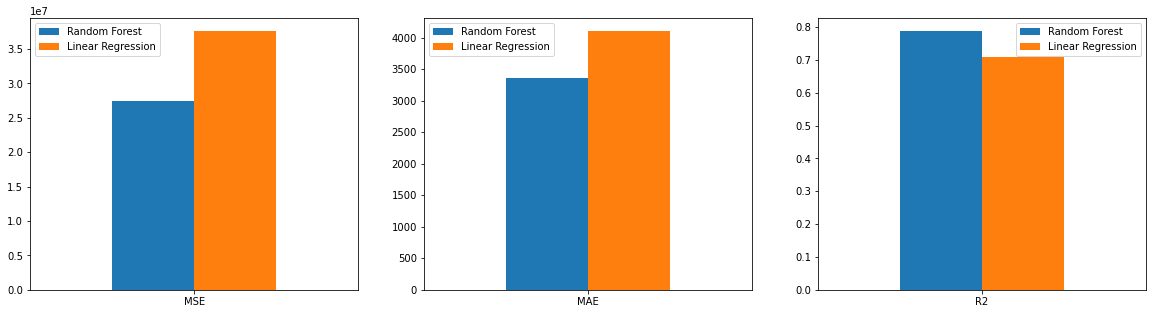

In [31]:
df_mse = pd.DataFrame({'Random Forest': RF_mse, 'Linear Regression': LR_mse}, index=['MSE'])
df_mae = pd.DataFrame({'Random Forest': RF_mae, 'Linear Regression': LR_mae}, index=['MAE'])
df_r2 = pd.DataFrame({'Random Forest': RF_r2, 'Linear Regression': LR_r2}, index=['R2'])

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

df_mse.plot.bar(rot=0, ax=axes[0])
df_mae.plot.bar(rot=0, ax=axes[1])
df_r2.plot.bar(rot=0, ax=axes[2])

plt.show()

### Conclusion

I added two dimension reduction algorithms to both the Random Forest and the Linear Regression search spaces, these are:

- SVD (Singular Value Decomposition) - Singular Value Decomposition is a popular technique for dimensionality reduction on sparse datasets, a sparse dataset is a dataset that contain many zero values.

- Isomap Embedding - Isomap Embedding creates an embedding of the dataset and attempts to preserve the relationships in the dataset.

The most performant Dimensionality reduction algorithm on both Random Forest and the Linear Regression models was SVD but both models showed a reduction in performance over the RFE algorithm from the example notebook. The example notebook resulted in both models using RFE (recursive feature elimination) for dimensionality reduction and achieved results of 0.857 on Random Forest and 0.747 on Linear Regression. SVD got results of 0.805 on Random Forest and 0.720 on Linear Regression. Isomap achieved significant lower cv scores 0.642 on Random Forest and 0.243 on Linear Regression.

The fact that the Random Forest consistently outperforms the Linear Regression suggests that the dataset is not linearly separable, in addition to this due to our encoding of the categorical features using one-hot-encoding (resulting in many zeros in the dataset), the dataset can be seen as a sparse dataset. SVD performs better on sparse datasets than Isomap and the results appear to validate this.